In [54]:
from pathlib import Path

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from timeit import default_timer as timer

import itertools

### Chargement des données

In [43]:
# Chargement du DataFrame contenant le chemin d'accès à chaque image et l'espèce correspondante (label)

df = pd.read_csv(Path("V2_Plant_Seedlings_DataFrame.csv"))
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,sharpness_score,image_size,square
0,Input\Maize\196.png,Maize,196.png,1260,1260,96.623133,95.263001,68.305443,86.730526,371.683979,1587600,square
1,Input\Cleavers\33.png,Cleavers,33.png,352,352,80.315397,70.118769,50.518635,66.984267,39.836262,123904,square
2,Input\Charlock\454.png,Charlock,454.png,990,990,80.529463,75.808330,55.868748,70.735514,305.574312,980100,square
3,Input\Small-flowered Cranesbill\5.png,Small-flowered Cranesbill,5.png,162,162,80.199131,71.348765,45.413733,65.653876,9.546821,26244,square
4,Input\Small-flowered Cranesbill\91.png,Small-flowered Cranesbill,91.png,323,323,83.221012,71.454773,45.279941,66.651909,31.808805,104329,square


### Séparation des jeux d'entraînement et de test

In [44]:
# Train/test split: 80% dans le jeu train, 20% dans le jeu test

train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])


### Pre-processing

In [45]:
# Paramètres de pre-processing

color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [46]:
# Instanciation du générateur de données 

# Générateur des données d'entraînement: avec augmentation "forte" des données
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,  # Fonction de pre-processing propre au modèle MobileNetV2
                                          shear_range=0.3,
                                          rotation_range=90,
                                          width_shift_range=0.3, 
                                          height_shift_range=0.3,
                                          zoom_range=0.4,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2)  # 20% du jeu train réservés pour évaluer le modèle au cours de l'entraînement

# Générateur des données de test: sans augmentation de données
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


In [47]:
# Instanciation des itérateurs associés aux trois jeux train, validation et test

train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                           x_col='filepath',
                                                           y_col='species',
                                                           target_size=target_size,
                                                           color_mode=color_mode,
                                                           class_mode='sparse',
                                                           batch_size=batch_size,
                                                           subset="training")
validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = test_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


### Construction du modèle, définition des callbacks

In [48]:
# Transfer learning sur la base du modèle MobileNetV2

# Chargement du modèle de base MobileNetV2 pré-entraîné sur la base de données ImageNet
base_model = MobileNetV2(include_top = False,   # On conserve uniquement la partie convolutionnelle du modèle de base
                         input_shape=(target_size[0],target_size[1],channels),
                         weights = 'imagenet',
                         pooling='avg')
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [49]:
# Création du modèle complet: construction fonctionnelle

inputs = Input(shape=(target_size[0],target_size[1],channels),name='Input')
          
# Définition des couches de classification
classif_layer1 = Dropout(rate=0.2,name='Dropout_layer_1')
classif_layer2 = Dense(units=256,activation='relu',name='Dense_layer_1')
classif_layer3 = Dropout(rate=0.2,name='Dropout_layer_2')
classif_layer4 = Dense(units=128,activation='relu',name='Dense_layer_2')
classif_layer5 = Dropout(rate=0.2,name='Dropout_layer_3')
output_layer = Dense(units=12,activation='softmax',name='Dense_layer_output')

# Assemblage du modèle
x = base_model(inputs)
x = classif_layer1(x)
x = classif_layer2(x)
x = classif_layer3(x)
x = classif_layer4(x)
x = classif_layer5(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 Dropout_layer_1 (Dropout)   (None, 1280)              0         
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               327936    
                                                                 
 Dropout_layer_2 (Dropout)   (None, 256)               0         
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                             

In [10]:
# Définition des callbacks

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=3,
                                         verbose=1)


# Callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [11]:
# Fonction permettant de charger un éventuel modèle précédemment entraîné, de compiler et de lancer l'entraînement

def model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=None,lr=1.e-3,nb_epochs=30):
    
    # Chargement des poids obtenus lors d'un précédent entraînement
    if loadweights_filepath != None:
        print("Loading model weights")
        model.load_weights(loadweights_filepath)
        
    # Compilation
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    model.optimizer.lr.assign(lr)    # Assignation forcée pour éviter l'utilisation du learning rate chargé avec les poids (bug Keras?)
    print("Model compilation OK, learning rate =",model.optimizer.lr.numpy())
    
    # Définition du callback ModelCheckPoint
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
    # Définition du callback CSV Logger (enregistrement de l'historique d'entraînement)
    csv_logger = CSVLogger(csvlogger_filepath,append=True)
    
    # Entraînement
    print("Launching training")
    training_history = model.fit(train_iterator,validation_data=validation_iterator,
                                 epochs=nb_epochs,
                                 steps_per_epoch=train_iterator.samples//batch_size,
                                 validation_steps=validation_iterator.samples//batch_size,
                                 callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                                 verbose=True)



### Entraînement du modèle

#### Etape 1: Entraînement avec les poids du modèle de base freezés

In [ ]:
# Freeze des poids du modèle de base
for layer in base_model.layers:
    layer.trainable = False    

In [3]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Freeze','best_weights.ckpt')
csvlogger_filepath = Path('Freeze','training_history.csv')

In [16]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath)

Compiling model
Model compilation OK, learning rate = 0.001
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 2.1083 - accuracy: 0.2886
Epoch 1: val_accuracy improved from -inf to 0.48843, saving model to mobilenetV2_strongaugm_nosegmentation\Freeze\best_weights.ckpt
110/110 [==============================] - 151s 1s/step - loss: 2.1083 - accuracy: 0.2886 - val_loss: 1.5252 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 1.5798 - accuracy: 0.4421
Epoch 2: val_accuracy improved from 0.48843 to 0.60764, saving model to mobilenetV2_strongaugm_nosegmentation\Freeze\best_weights.ckpt
110/110 [==============================] - 105s 958ms/step - loss: 1.5798 - accuracy: 0.4421 - val_loss: 1.1739 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 1.4114 - accuracy: 0.5016
Epoch 3: val_accuracy improved from 0.60764 to 0.64005, saving model to m

In [17]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 52.0 minutes.


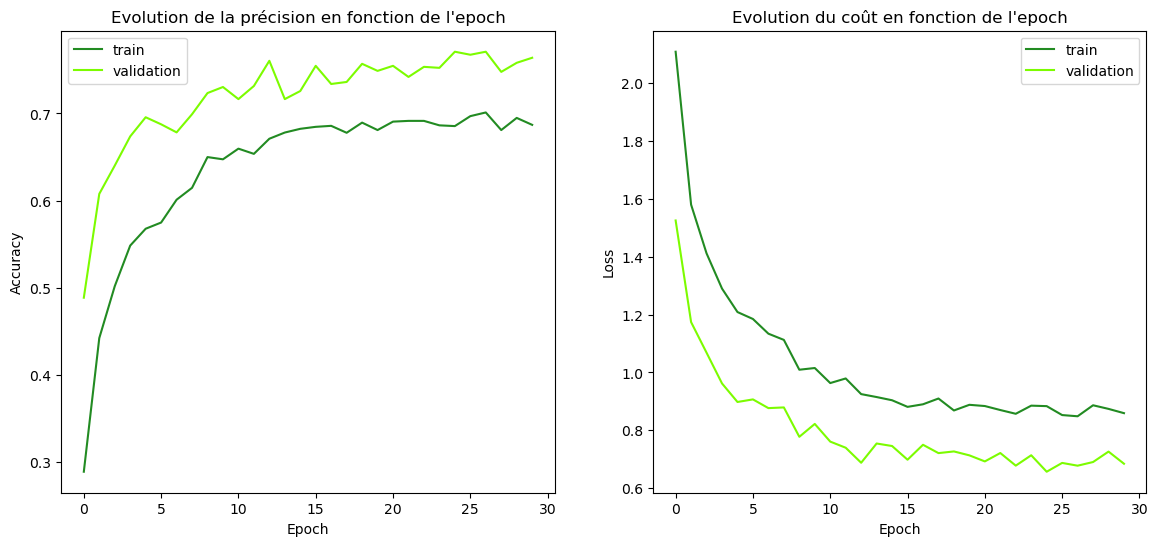

In [30]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement

def plot_history():
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');
    
plot_history()

#### Etape 2: Fine-tuning du modèle par de-freezes successifs du modèle de base et ajustement du learning rate

##### Etape 2.1: De-freeze des 2 derniers blocs (15 et 16) du modèle de base

In [20]:
# Identification des couches à de-freezer
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)


0 input_3 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [21]:
for layer in base_model.layers[134:]:
    layer.trainable = True

In [23]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_1','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_1','training_history.csv')
loadweights_filepath = Path('Freeze','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 1.1125 - accuracy: 0.6280
Epoch 1: val_accuracy improved from -inf to 0.66435, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_1\best_weights.ckpt
110/110 [==============================] - 109s 967ms/step - loss: 1.1125 - accuracy: 0.6280 - val_loss: 1.1207 - val_accuracy: 0.6644 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.7045
Epoch 2: val_accuracy did not improve from 0.66435
110/110 [==============================] - 117s 1s/step - loss: 0.8454 - accuracy: 0.7045 - val_loss: 1.4616 - val_accuracy: 0.6076 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.7677 - accuracy: 0.7284
Epoch 3: val_accuracy did not improve from 0.66435
110/110 [==============================] - 113s 1s/step - loss: 0.7677 -

Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.4130 - accuracy: 0.8488
Epoch 24: val_accuracy did not improve from 0.88079
110/110 [==============================] - 118s 1s/step - loss: 0.4130 - accuracy: 0.8488 - val_loss: 0.3865 - val_accuracy: 0.8553 - lr: 5.0000e-05
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8474
Epoch 25: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 25: val_accuracy did not improve from 0.88079
110/110 [==============================] - 123s 1s/step - loss: 0.4380 - accuracy: 0.8474 - val_loss: 0.3678 - val_accuracy: 0.8623 - lr: 5.0000e-05
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.3870 - accuracy: 0.8577
Epoch 26: val_accuracy did not improve from 0.88079
110/110 [==============================] - 122s 1s/step - loss: 0.3870 - accuracy: 0.8577 - val_loss: 0.3778 - val_accuracy: 0.8808 - lr: 2.5000e-05
Epoch 27/30
110/110 [=======

In [24]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 57.0 minutes.


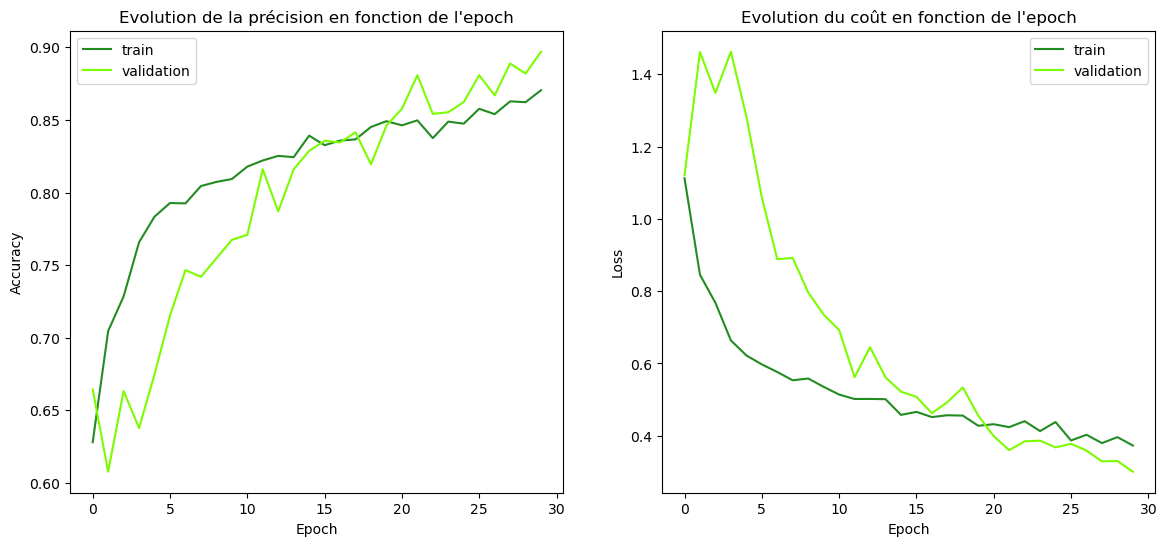

In [34]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.2: De-freeze des blocs 13 et 14 du modèle de base

In [27]:
for layer in base_model.layers[116:]:
    layer.trainable = True

In [29]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_2','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_2','training_history.csv')
loadweights_filepath = Path('UnFreeze_1','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.8138
Epoch 1: val_accuracy improved from -inf to 0.81366, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_2\best_weights.ckpt
110/110 [==============================] - 131s 1s/step - loss: 0.5487 - accuracy: 0.8138 - val_loss: 0.5393 - val_accuracy: 0.8137 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.8318
Epoch 2: val_accuracy did not improve from 0.81366
110/110 [==============================] - 119s 1s/step - loss: 0.4788 - accuracy: 0.8318 - val_loss: 0.5938 - val_accuracy: 0.8090 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8454
Epoch 3: val_accuracy did not improve from 0.81366
110/110 [==============================] - 113s 1s/step - loss: 0.4446 - ac

Epoch 25/40
110/110 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9095
Epoch 25: val_accuracy did not improve from 0.91088
110/110 [==============================] - 107s 969ms/step - loss: 0.2590 - accuracy: 0.9095 - val_loss: 0.2514 - val_accuracy: 0.9028 - lr: 1.2500e-05
Epoch 26/40
110/110 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9089
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 26: val_accuracy improved from 0.91088 to 0.91435, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_2\best_weights.ckpt
110/110 [==============================] - 104s 943ms/step - loss: 0.2458 - accuracy: 0.9089 - val_loss: 0.2536 - val_accuracy: 0.9144 - lr: 1.2500e-05
Epoch 27/40
110/110 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9137
Epoch 27: val_accuracy improved from 0.91435 to 0.92477, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_2\best_weights.c

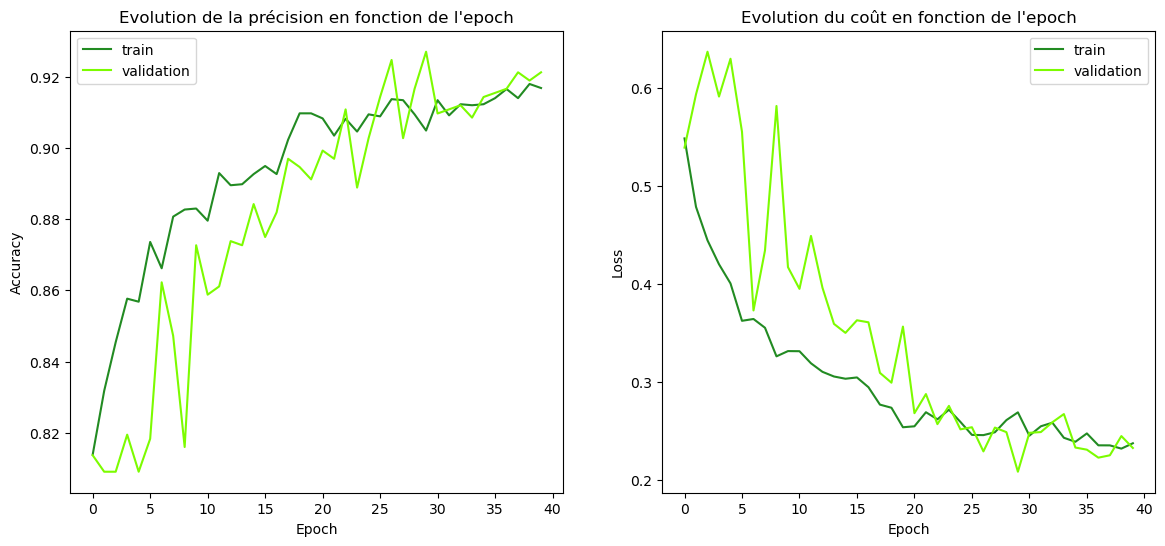

In [11]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.3: De-freeze des blocs 11 et 12 du modèle de base

In [15]:
for layer in base_model.layers[98:]:
    layer.trainable = True

In [17]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_3','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_3','training_history.csv')
loadweights_filepath = Path('UnFreeze_2','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.8619
Epoch 1: val_accuracy improved from -inf to 0.87963, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_3\best_weights.ckpt
110/110 [==============================] - 327s 3s/step - loss: 0.3908 - accuracy: 0.8619 - val_loss: 0.3304 - val_accuracy: 0.8796 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8796
Epoch 2: val_accuracy improved from 0.87963 to 0.89583, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_3\best_weights.ckpt
110/110 [==============================] - 218s 2s/step - loss: 0.3504 - accuracy: 0.8796 - val_loss: 0.3487 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.3104 - accuracy: 0.8927
Epoch 3: val_accuracy did not improve 

Epoch 25/40
110/110 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9354
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 25: val_accuracy did not improve from 0.93634
110/110 [==============================] - 125s 1s/step - loss: 0.1733 - accuracy: 0.9354 - val_loss: 0.1933 - val_accuracy: 0.9271 - lr: 3.1250e-06
Epoch 26/40
110/110 [==============================] - ETA: 0s - loss: 0.1823 - accuracy: 0.9397
Epoch 26: val_accuracy improved from 0.93634 to 0.93866, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_3\best_weights.ckpt
110/110 [==============================] - 120s 1s/step - loss: 0.1823 - accuracy: 0.9397 - val_loss: 0.1922 - val_accuracy: 0.9387 - lr: 1.5625e-06
Epoch 27/40
110/110 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.9439
Epoch 27: val_accuracy did not improve from 0.93866
110/110 [==============================] - 122s 1s/step - loss: 0.1644 - accuracy: 0.9439 

In [18]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 89.0 minutes.


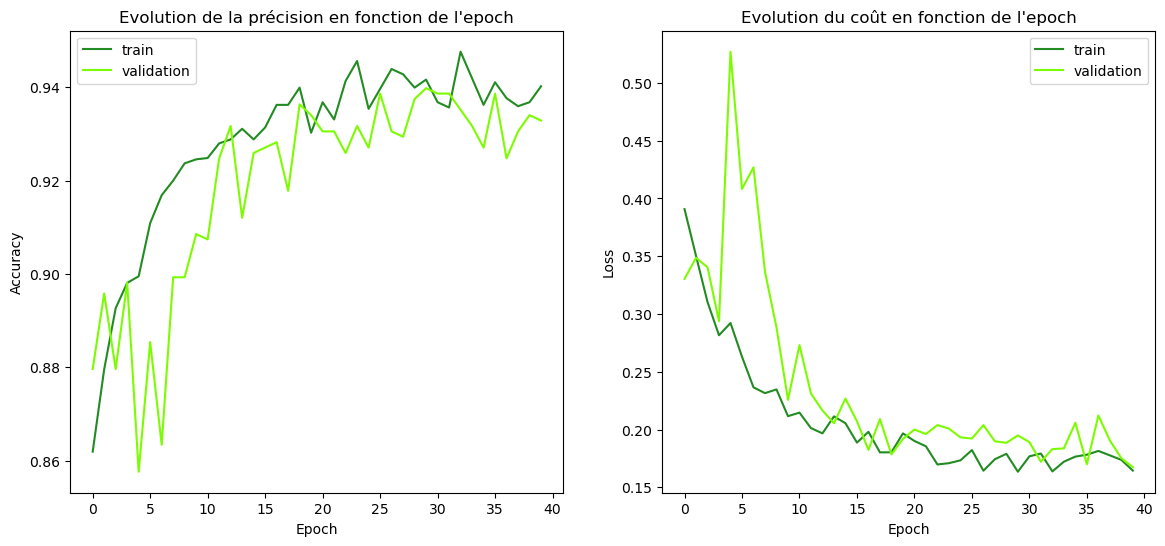

In [13]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.4: De-freeze des blocs 9 et 10 du modèle de base

In [21]:
for layer in base_model.layers[81:]:
    layer.trainable = True

In [23]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_4','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_4','training_history.csv')
loadweights_filepath = Path('UnFreeze_3','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9143
Epoch 1: val_accuracy improved from -inf to 0.91898, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_4\best_weights.ckpt
110/110 [==============================] - 156s 1s/step - loss: 0.2453 - accuracy: 0.9143 - val_loss: 0.2558 - val_accuracy: 0.9190 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.9152
Epoch 2: val_accuracy did not improve from 0.91898
110/110 [==============================] - 170s 2s/step - loss: 0.2369 - accuracy: 0.9152 - val_loss: 0.3337 - val_accuracy: 0.9120 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9229
Epoch 3: val_accuracy did not improve from 0.91898
110/110 [==============================] - 165s 2s/step - loss: 0.2391 - ac

In [24]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 116.0 minutes.


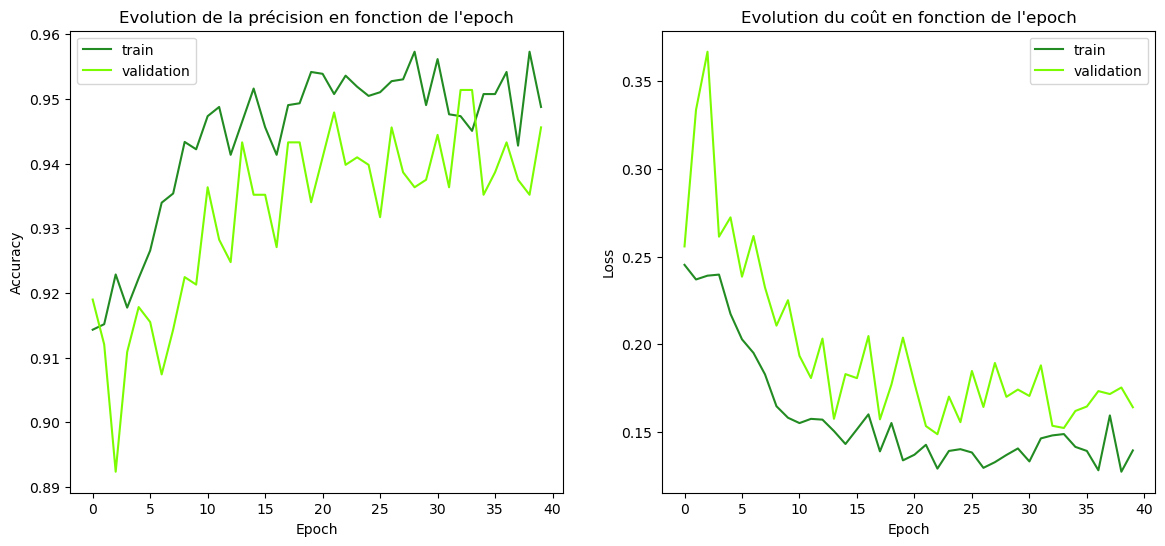

In [16]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.5: De-freeze des blocs 7 et 8 du modèle de base

In [28]:
for layer in base_model.layers[63:]:
    layer.trainable = True

In [ ]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_5','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_5','training_history.csv')
loadweights_filepath = Path('UnFreeze_4','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9197
Epoch 1: val_accuracy improved from -inf to 0.92593, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_5\best_weights.ckpt
110/110 [==============================] - 192s 2s/step - loss: 0.2325 - accuracy: 0.9197 - val_loss: 0.2179 - val_accuracy: 0.9259 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9260
Epoch 2: val_accuracy improved from 0.92593 to 0.92940, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_5\best_weights.ckpt
110/110 [==============================] - 184s 2s/step - loss: 0.2157 - accuracy: 0.9260 - val_loss: 0.2010 - val_accuracy: 0.9294 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9310
Epoch 3: val_accuracy did not improve 

Epoch 25/40
110/110 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9610
Epoch 25: val_accuracy improved from 0.95139 to 0.95255, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_5\best_weights.ckpt
110/110 [==============================] - 212s 2s/step - loss: 0.1140 - accuracy: 0.9610 - val_loss: 0.1386 - val_accuracy: 0.9525 - lr: 7.8125e-07
Epoch 26/40
110/110 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9570
Epoch 26: val_accuracy did not improve from 0.95255
110/110 [==============================] - 182s 2s/step - loss: 0.1223 - accuracy: 0.9570 - val_loss: 0.1610 - val_accuracy: 0.9479 - lr: 7.8125e-07
Epoch 27/40
110/110 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9653
Epoch 27: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 27: val_accuracy did not improve from 0.95255
110/110 [==============================] - 167s 2s/step - loss: 0.0998 - accuracy: 0.9653

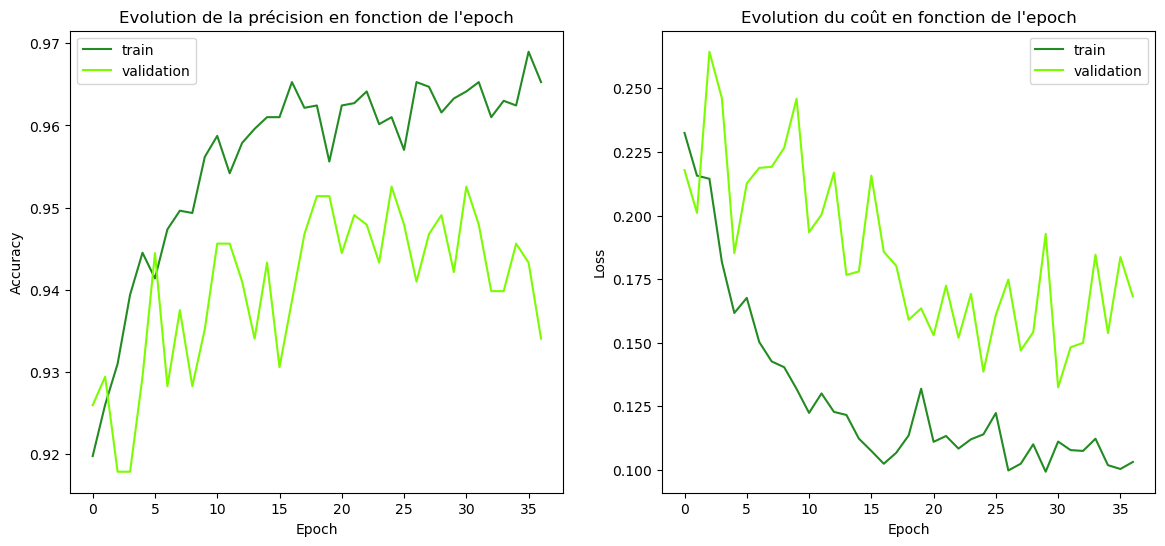

In [32]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.6: De-freeze des blocs 5 et 6 du modèle de base

In [15]:
for layer in base_model.layers[45:]:
    layer.trainable = True

In [17]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_6','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_6','training_history.csv')
loadweights_filepath = Path('UnFreeze_5','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9268
Epoch 1: val_accuracy improved from -inf to 0.92014, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_6\best_weights.ckpt
110/110 [==============================] - 263s 2s/step - loss: 0.2119 - accuracy: 0.9268 - val_loss: 0.2422 - val_accuracy: 0.9201 - lr: 1.0000e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9334
Epoch 2: val_accuracy did not improve from 0.92014
110/110 [==============================] - 271s 2s/step - loss: 0.1990 - accuracy: 0.9334 - val_loss: 0.2832 - val_accuracy: 0.9097 - lr: 1.0000e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9428
Epoch 3: val_accuracy improved from 0.92014 to 0.92361, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_6\best_

In [18]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 174.0 minutes.


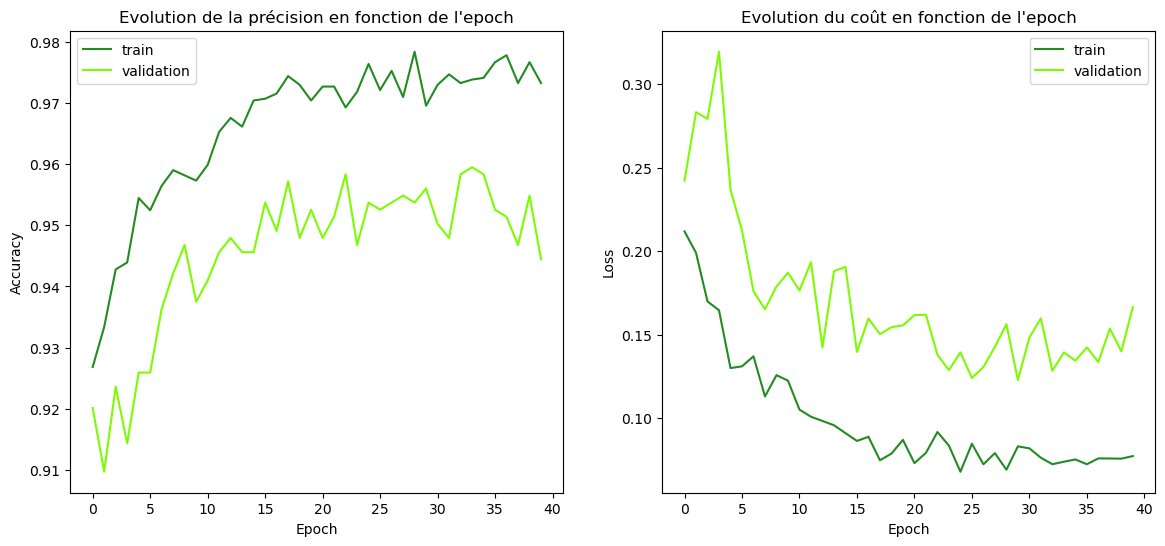

In [36]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.7: De-freeze des blocs 3 et 4 du modèle de base

In [21]:
for layer in base_model.layers[27:]:
    layer.trainable = True

In [22]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_7','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_7','training_history.csv')
loadweights_filepath = Path('UnFreeze_6','best_weights.ckpt')
lr=1.e-4
nb_epochs=30

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9553
Epoch 1: val_accuracy improved from -inf to 0.92361, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_7\best_weights.ckpt
110/110 [==============================] - 315s 3s/step - loss: 0.1244 - accuracy: 0.9553 - val_loss: 0.2332 - val_accuracy: 0.9236 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9607
Epoch 2: val_accuracy improved from 0.92361 to 0.94329, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_7\best_weights.ckpt
110/110 [==============================] - 289s 3s/step - loss: 0.1146 - accuracy: 0.9607 - val_loss: 0.1968 - val_accuracy: 0.9433 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9570
Epoch 3: val_accuracy did not improve 

Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9784
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 25: val_accuracy did not improve from 0.96528
110/110 [==============================] - 301s 3s/step - loss: 0.0584 - accuracy: 0.9784 - val_loss: 0.1267 - val_accuracy: 0.9618 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9775
Epoch 26: val_accuracy did not improve from 0.96528
110/110 [==============================] - 308s 3s/step - loss: 0.0651 - accuracy: 0.9775 - val_loss: 0.1704 - val_accuracy: 0.9606 - lr: 1.5625e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9789
Epoch 27: val_accuracy did not improve from 0.96528
110/110 [==============================] - 318s 3s/step - loss: 0.0565 - accuracy: 0.9789 - val_loss: 0.1769 - val_accuracy: 0.9502 - lr: 1.5625e-06
Epoch 28/30
110/110 [========

In [23]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 148.0 minutes.


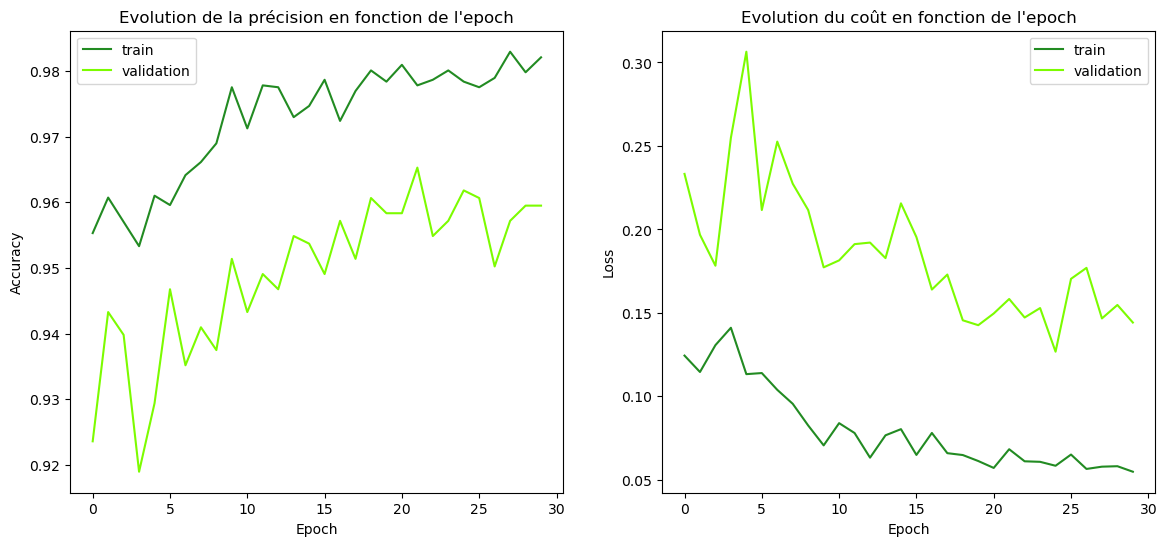

In [38]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.8: De-freeze complet du modèle de base

In [21]:
for layer in base_model.layers:
    layer.trainable = True

In [28]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_8','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_8','training_history.csv')
loadweights_filepath = Path('UnFreeze_7','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Loading model weights
Compiling model
Model compilation OK, learning rate = 1e-04
Launching training
Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9616
Epoch 1: val_accuracy improved from -inf to 0.93403, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_8\best_weights.ckpt
110/110 [==============================] - 393s 3s/step - loss: 0.1134 - accuracy: 0.9616 - val_loss: 0.2510 - val_accuracy: 0.9340 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.1037 - accuracy: 0.9607
Epoch 2: val_accuracy improved from 0.93403 to 0.93519, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_8\best_weights.ckpt
110/110 [==============================] - 427s 4s/step - loss: 0.1037 - accuracy: 0.9607 - val_loss: 0.2798 - val_accuracy: 0.9352 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9644
Epoch 3: val_accuracy improved from 0.

Epoch 25/35
110/110 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9826
Epoch 25: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 25: val_accuracy improved from 0.96181 to 0.96644, saving model to mobilenetV2_strongaugm_nosegmentation\UnFreeze_8\best_weights.ckpt
110/110 [==============================] - 409s 4s/step - loss: 0.0525 - accuracy: 0.9826 - val_loss: 0.1531 - val_accuracy: 0.9664 - lr: 1.5625e-06
Epoch 26/35
110/110 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9781
Epoch 26: val_accuracy did not improve from 0.96644
110/110 [==============================] - 428s 4s/step - loss: 0.0567 - accuracy: 0.9781 - val_loss: 0.1539 - val_accuracy: 0.9583 - lr: 7.8125e-07
Epoch 27/35
110/110 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9809
Epoch 27: val_accuracy did not improve from 0.96644
110/110 [==============================] - 404s 4s/step - loss: 0.0622 - accuracy: 0.9809 

In [29]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 237.0 minutes.


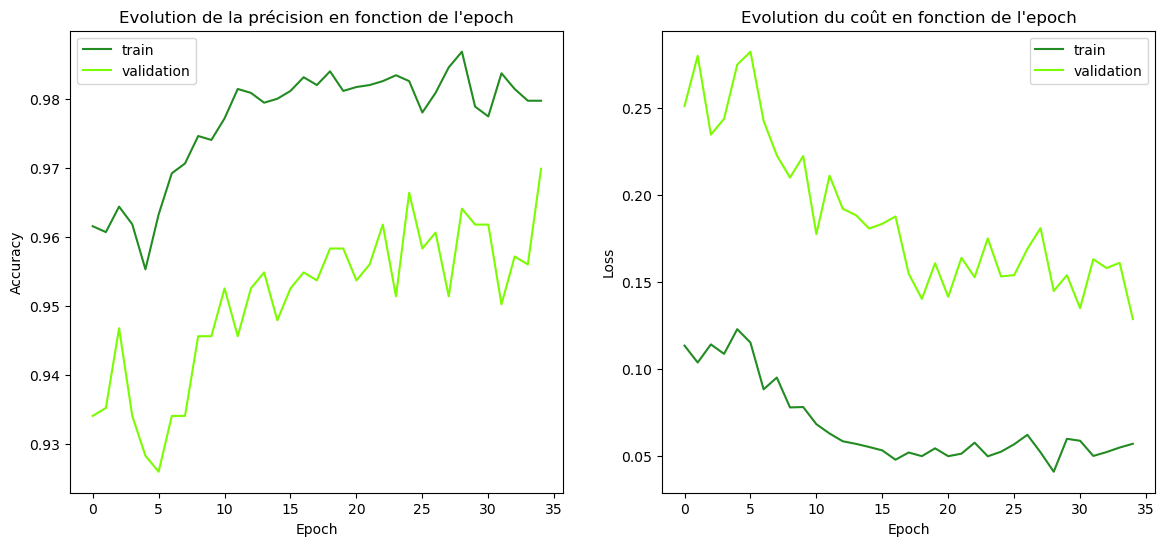

In [40]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

#### Sauvegarde du modèle final (intégralement de-freezé et entraîné) avec les meilleurs poids

In [59]:
# Chargement des meilleurs poids
model.load_weights(Path('UnFreeze_8','best_weights.ckpt'))

In [67]:
# Sauvegarde au format TensorFlow SavedModel
saving_filepath = Path('Final_model')
model.save(saving_filepath)

INFO:tensorflow:Assets written to: mobilenetV2_strongaugm_nosegmentation\Final_model\assets


INFO:tensorflow:Assets written to: mobilenetV2_strongaugm_nosegmentation\Final_model\assets


#### Analyse de l'entraînement

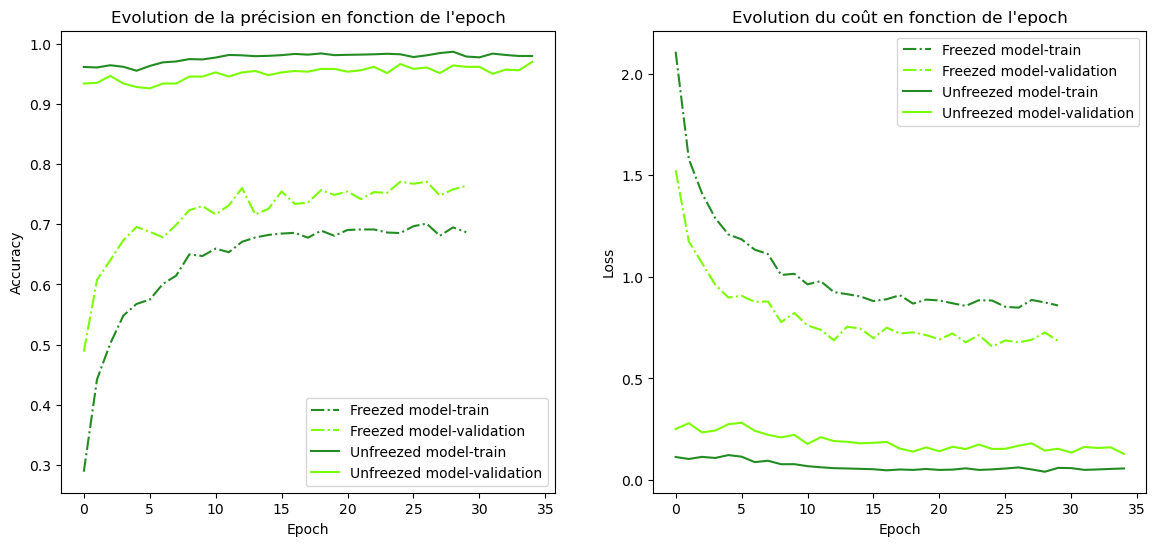

In [39]:
# Visualisation des courbes de convergence de la fonction de coût et de l'accuracy au long de l'entraînement 
# pour le modèle freezé, et pour le modèle intégralemet de-freezé
csvlogger_filepath_freeze = Path('Freeze','training_history.csv')
csvlogger_filepath_unfreeze = Path('UnFreeze_8','training_history.csv')


training_history_freeze = pd.read_csv(csvlogger_filepath_freeze,index_col = 'epoch')
training_history_unfreeze = pd.read_csv(csvlogger_filepath_unfreeze,index_col = 'epoch')
    
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(training_history_freeze['accuracy'],linestyle='-.',color='forestgreen',label="Freezed model-train")
ax[0].plot(training_history_freeze['val_accuracy'],linestyle='-.',color='lawngreen',label="Freezed model-validation")
ax[0].plot(training_history_unfreeze['accuracy'], color='forestgreen',label="Unfreezed model-train")
ax[0].plot(training_history_unfreeze['val_accuracy'], color='lawngreen',label="Unfreezed model-validation")
ax[0].set_title("Evolution de la précision en fonction de l'epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc='best');
ax[1].plot(training_history_freeze['loss'],linestyle='-.',color='forestgreen',label="Freezed model-train")
ax[1].plot(training_history_freeze['val_loss'],linestyle='-.',color='lawngreen',label="Freezed model-validation")
ax[1].plot(training_history_unfreeze['loss'],color='forestgreen',label="Unfreezed model-train")
ax[1].plot(training_history_unfreeze['val_loss'],color='lawngreen',label="Unfreezed model-validation")
ax[1].set_title("Evolution du coût en fonction de l'epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend(loc='best');
    


In [43]:
# Visualisation des courbes de de-freeze

# Récupération des valeurs de loss et accuracy pour le modèle freezé et les de-freezes successifs
loss=[]
accuracy=[]
val_loss=[]
val_accuracy=[]

# Modèle freezé
loadweights_filepath = Path('Freeze','best_weights.ckpt')
print("Loading model weights - Freeze")
model.load_weights(loadweights_filepath)
print("Compiling model")
model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
print("Evaluating model")
train_res = model.evaluate(train_iterator)
loss.append(train_res[0])
accuracy.append(train_res[1])
val_res = model.evaluate(validation_iterator)
val_loss.append(val_res[0])
val_accuracy.append(val_res[1])

# De-freezes successifs
nb_defreeze = 8
for k in range(nb_defreeze):
    directory = "UnFreeze_"+str(k+1)
    loadweights_filepath = Path(directory,'best_weights.ckpt')
    print("Loading model weights - Unfreeze",str(k+1))
    model.load_weights(loadweights_filepath)
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    print("Evaluating model")
    train_res = model.evaluate(train_iterator)
    loss.append(train_res[0])
    accuracy.append(train_res[1])
    val_res = model.evaluate(validation_iterator)
    val_loss.append(val_res[0])
    val_accuracy.append(val_res[1])

Loading model weights - Freeze
Compiling model
Evaluating model
28/28 [==============================] - 26s 919ms/step - loss: 0.6655 - accuracy: 0.7540
Loading model weights - Unfreeze 1
Compiling model
Evaluating model
28/28 [==============================] - 27s 961ms/step - loss: 0.3178 - accuracy: 0.8883
Loading model weights - Unfreeze 2
Compiling model
Evaluating model
28/28 [==============================] - 28s 979ms/step - loss: 0.2443 - accuracy: 0.9187
Loading model weights - Unfreeze 3
Compiling model
Evaluating model
28/28 [==============================] - 27s 944ms/step - loss: 0.1873 - accuracy: 0.9289
Loading model weights - Unfreeze 4
Compiling model
Evaluating model
28/28 [==============================] - 27s 955ms/step - loss: 0.1658 - accuracy: 0.9458
Loading model weights - Unfreeze 5
Compiling model
Evaluating model
28/28 [==============================] - 27s 952ms/step - loss: 0.1707 - accuracy: 0.9470
Loading model weights - Unfreeze 6
Compiling model
Evalu

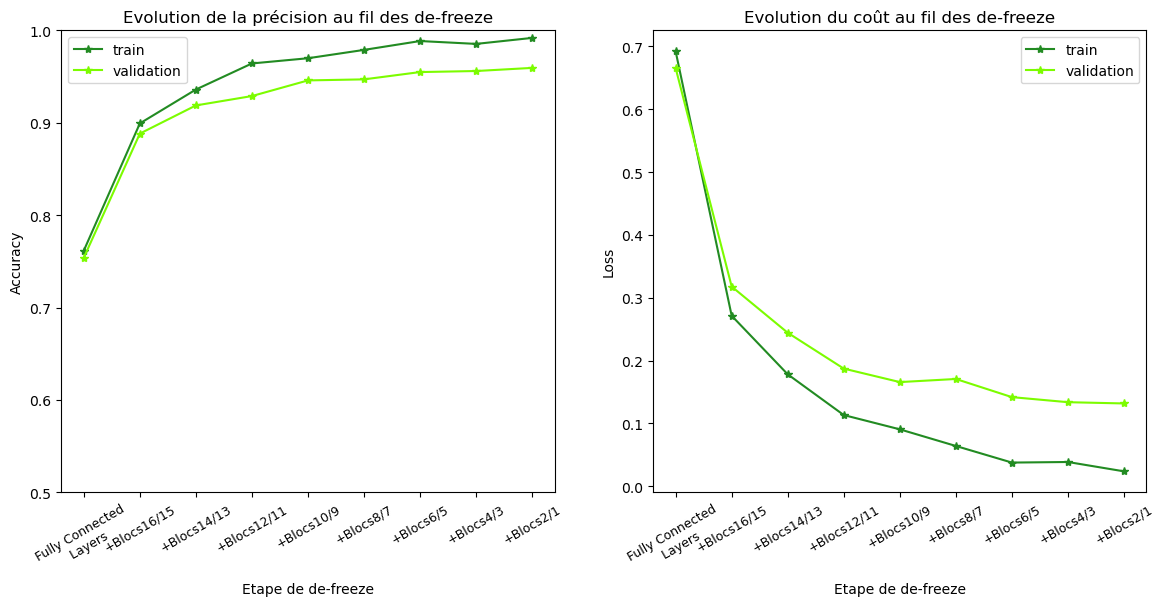

In [53]:
# Tracé des courbes de de-freeze

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(accuracy, color='forestgreen', marker = "*")
ax[0].plot(val_accuracy, color='lawngreen', marker = "*")
ax[0].set_title("Evolution de la précision au fil des de-freeze")
ax[0].set_xlabel("Etape de de-freeze")
ax[0].set_ylabel("Accuracy")
xticklabels=["Fully Connected\n Layers", "+Blocs16/15", "+Blocs14/13", "+Blocs12/11", "+Blocs10/9", 
             "+Blocs8/7", "+Blocs6/5", "+Blocs4/3", "+Blocs2/1"]
ax[0].set_xticks(range(9))
ax[0].set_xticklabels(xticklabels, rotation=30, fontsize=9)
ax[0].set_ylim(0.5,1)
ax[0].legend(['train', 'validation'], loc='best');
ax[1].plot(loss, color='forestgreen', marker = "*")
ax[1].plot(val_loss, color='lawngreen', marker = "*")
ax[1].set_title("Evolution du coût au fil des de-freeze")
ax[1].set_xlabel("Etape de de-freeze")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(9))
ax[1].set_xticklabels(xticklabels, rotation=30, fontsize=9)
ax[1].legend(['train', 'validation'], loc='best');

### Evaluation du modèle

In [ ]:
# Chargement du modèle final
model = load_model(saving_filepath)

In [65]:
# Evaluation sur les jeux train, validation et test
res = pd.DataFrame(index=['train','validation','test'],columns=['loss','accuracy'])
res.iloc[0,:] = model.evaluate(train_iterator)
res.iloc[1,:] = model.evaluate(validation_iterator)
res.iloc[2,:] = model.evaluate(test_iterator)

# Sauvegarde dans un fichier CSV
res.to_csv('mobilenetV2_unfreezed_strongaugm_nosegmentation_results.csv')

35/35 [==============================] - 17s 485ms/step - loss: 0.1897 - accuracy: 0.9639


In [66]:
# Affichage des résultats
res

,loss,accuracy
train,0.025785,0.990691
validation,0.150269,0.959368
test,0.189672,0.963899


35/35 [==============================] - 13s 349ms/step
                           precision    recall  f1-score   support

              Black-grass       0.88      0.61      0.72        62
                 Charlock       1.00      1.00      1.00        90
                 Cleavers       1.00      1.00      1.00        67
         Common Chickweed       0.99      0.99      0.99       143
             Common wheat       0.98      0.96      0.97        51
                  Fat Hen       0.99      0.99      0.99       108
         Loose Silky-bent       0.84      0.97      0.90       152
                    Maize       1.00      0.96      0.98        51
        Scentless Mayweed       0.98      0.98      0.98       121
         Shepherd's Purse       0.98      0.96      0.97        55
Small-flowered Cranesbill       1.00      1.00      1.00       115
               Sugar beet       1.00      0.98      0.99        93

                 accuracy                           0.96      1108
    

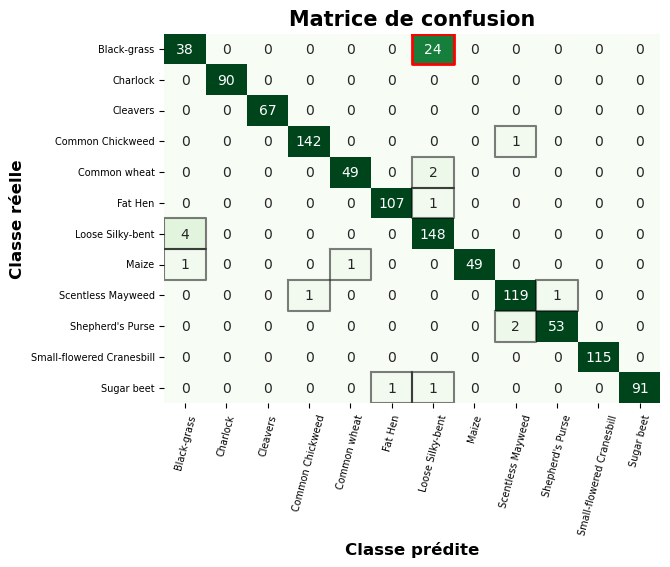

In [56]:
# Rapport de classification & matrice de confusion

def show_metrics():
    y_true = test_iterator.classes
    y_pred = model.predict(test_iterator).argmax(axis=-1)

    print(classification_report(y_true, y_pred, target_names = test_iterator.class_indices.keys()))
    
    matrix = confusion_matrix(y_true, y_pred)
    classes = test_iterator.class_indices.keys()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);

show_metrics()